# Exercise7：TensorBoard進階技巧

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/taipeitechmmslab/MMSLAB-TF2/blob/master/Exercise/Exercise7.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/taipeitechmmslab/MMSLAB-TF2/blob/master/Exercise/Exercise7.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## tf.summary

tf.summary是TensorFlow提供TensorBoard低階API指令，主要是用來紀錄log檔。
以下整理了幾個常用功能：
- tf.scalar：儲存顯示如損失、指標或學習率等的變化趨勢。
- tf.image：儲存顯示影像。
- tf.audio：儲存顯示可播放的音頻。
- tf.histogram：儲存顯示模型權重。
- tf.text：儲存顯示一段文字。


In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### 創建TensorBoard log檔

In [2]:
summary_writer = tf.summary.create_file_writer('lab7-logs-summary')

### Scalar

In [3]:
# 在0~2π之間產生100個點
x = np.linspace(0, 2 * np.pi , 100)
# 將100個點帶入sin函數中
data = np.sin(x)
with summary_writer.as_default():  # summary_writer作為預設寫入的紀錄檔
    for i, y in enumerate(data):
        tf.summary.scalar('sin', y, step=i)  # 存入數值(y為數值，i為時間軸)

### Image

1. 儲存一張影像在紀錄檔中並顯示

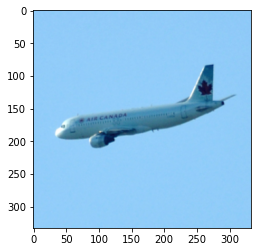

In [4]:
# 建立讀取影像的函數
def read_img(file):
    image_string = tf.io.read_file(file)  # 讀取檔案
    # 將讀入檔案以影像格式來解碼
    image_decode = tf.image.decode_image(image_string)
    # 將影像增加一個維度(number,height,width,channel)方便之後存入紀錄檔中
    # image_decode = tf.expand_dims(image_decode, axis=0)
    return image_decode

img = read_img('../image/airplane.png')  # 讀入影像資訊
plt.imshow(img)  # 顯示讀入的影像資訊

In [5]:
image_string = tf.io.read_file('../image/airplane.png')  # 讀取檔案
image_decode = tf.image.decode_image(image_string)

In [6]:
with summary_writer.as_default():  # summary_writer作為預設寫入的紀錄檔
    tf.summary.image("Airplane", [image_decode], step=0)  # 存入影像資訊

2. 一次儲存五張影像到紀錄檔中並顯示

In [7]:
!ls image/

1-2.png


In [8]:
img_files = ['airplane_zoom.png', 'airplane_flip.png', 'airplane_color.png', 'airplane_rot.png',
             'airplane.png']  # 創建一個陣列用來儲存讀入的影像 

imgs = [] 

for file in img_files: 
    imgs.append(read_img('../image/'+file))  # 讀取影像並存入陣列中 

with summary_writer.as_default():  # summary_writer作為預設寫入的紀錄檔 
    # 一次存入五張影像(注意:如果max_outputs沒設定為5，就只會儲存3張影像) 
    tf.summary.image("Airplane Augmentation", imgs, max_outputs=5, step=0) 

3. 將五張影像以不同Step(時間)儲存

In [9]:
with summary_writer.as_default():  # summary_writer作為預設寫入的紀錄檔
    # 每次儲存一張影像，並儲存在不同Step中
    for i, img in enumerate(imgs):
        tf.summary.image("Save image each step", [img], step=i)

### Text

In [10]:
# 建立一個陣列，裡面包含了對話記錄
texts = ["小明：Cubee小助理最近好想學深度學習的技術哦!", 
         "Cubee：這是當然的阿，這可現今最火的技術呢!", 
         "小明：那我該如何入門呢?", 
         "Cubee：推薦你一本書「輕鬆學會Google TensorFlow2.0深度學習」。", 
         "小明：這本書沒有深度學習經驗的人也能學會嗎?", 
         "Cubee：這是當然的，你只需要基礎Python能力就可以學會了!", 
         "小明：太好了那我要趕快去買了!"]

with summary_writer.as_default():  # summary_writer作為預設寫入的紀錄檔
    # 將每一段字串資訊以不同Step存入到記錄檔中
    for i, text in enumerate(texts):
        tf.summary.text("Chat record", text, step=i)

### Audio

In [11]:
# 建立讀取音訊的函數
def read_audio(file):
    audio_string = tf.io.read_file(file)  # 讀取檔案
    # 將讀入檔案以音訊格式來解碼
    audio, fs = tf.audio.decode_wav(audio_string)
    # 因為tf.summary.audio要求輸入格式為[k(clips), t(frames), c(channels)]
    # 而解碼後的音訊只有[t(frames), c(channels)]，所以需要增加一個維度給音訊
    audio = tf.expand_dims(audio, axis=0)
    return audio, fs

audio, fs = read_audio('../audio/cat.wav')  # 讀取音訊檔

with summary_writer.as_default():  # summary_writer作為預設寫入的紀錄檔
    tf.summary.audio('cat', audio, fs, step=0)  # 存入音訊資訊

### Histogram

目前 TensorFlow-gpu 2.0-alpha有問題，等待下一版修復。

https://github.com/tensorflow/tensorboard/issues/1993

建立一個常態分佈

In [12]:
data = tf.random.normal([64, 100], dtype=tf.float64)

儲存常態分佈分佈

In [13]:
with summary_writer.as_default():
    tf.summary.histogram('Normal distribution', data, step=0)

儲存多個常態分佈，並且各個之間平均值都相差0.01

In [14]:
with summary_writer.as_default():
    for i, offset in enumerate(tf.range(0, 10, delta=0.1, dtype=tf.float64)):
        tf.summary.histogram('Normal distribution 2', data+offset, step=i)

# 實驗一：使用tf.summary.image紀錄訓練結果

### Import 必要套件

In [7]:
import os
import io
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from preprocessing import parse_aug_fn, parse_fn

### Confusion matrix

Confusion matrix函數：透過tf.math.confusion_matrix來計算Confusion matrix。

In [2]:
y_true = [2, 1, 0, 2, 2, 0, 1, 1]
y_pred = [0, 1, 0, 2, 2, 0, 2, 1]
cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=3).numpy()
print(cm)

[[2 0 0]
 [0 2 1]
 [1 0 2]]


建立plot_confusion_matrix函式：將剛剛上方計算的Confusion matrix陣列以Matplotlib圖片來表示，而Confusion matrix中的數字改成百分比型式。

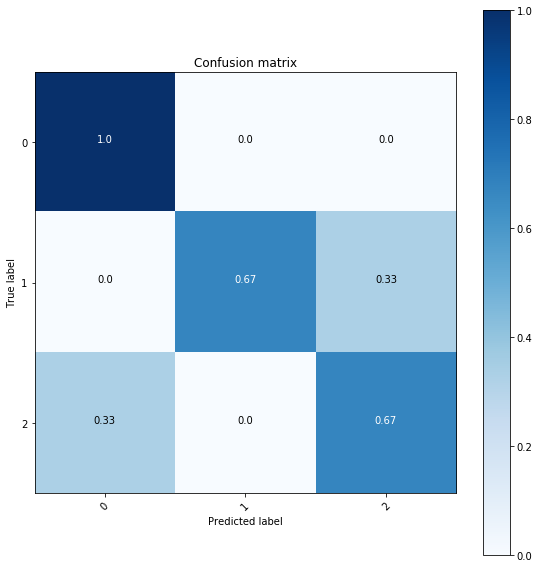

In [7]:
def plot_confusion_matrix(cm, class_names):
    """
    產生一張圖表示的Confusion matrix
    
    Args:
    cm (shape = [n, n]): 傳入Confusion matrix
    class_names (shape = [n]): 傳入類別
    """
    # 標準化confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    tick_index = np.arange(len(class_names))
    # matplotlib 3.1.1 bug，如果不設定ylim在[-0.5~2.5]，圖片y軸範圍會被縮小成[0~2]
    plt.ylim([-0.5, 2.5])
    # Y軸顯示類別名稱
    plt.yticks(tick_index, class_names)
    # X軸顯示類別名稱，並將類別名稱旋轉45度(避免文字重疊)
    plt.xticks(tick_index, class_names, rotation=45)
    # 再圖片右邊產生一條顏色刻度條
    plt.colorbar()

    # 在每一格Confusion matrix輸入預測百分比
    threshold = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            # 如果格內背景顏色太深使用白色文字顯示，反之使用黑色文字
            color = "white" if cm[i, j] > threshold else "black"
            plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
            
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # 將圖片的位置進行調整，避免x或y軸的文字被遮擋
    plt.tight_layout()
    return figure

# Example
img = plot_confusion_matrix(cm, [0, 1, 2])

建立plot_to_image函數：將Matplotlib圖片轉TensorFlow型式的圖片，這樣才能夠透過tf.summary.image紀錄影像到TensorBoard。

In [5]:
def plot_to_image(figure):
    """將Matplotlib plot的圖片轉TensorFlow的張量格式"""
    # 將Matplotlib plot的圖片以PNG的格式儲存到記憶體中
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # 關閉plt圖片，防止圖片直接顯示在Jupyter notebook介面中
    plt.close(figure)
    buf.seek(0)
    # 將記憶體中的資料轉成TensorFlow格式
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)
    return image

In [6]:
# Example
y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2]
cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=3).numpy()
img = plot_confusion_matrix(cm, [0, 1, 2])
img_show = plot_to_image(img)

### 創建Callback函數
創建回調函數：訓練過程中每個epoch結束，會產生一張Confusion matrix的圖片，並將圖片紀錄在Tensorboard上。

In [7]:
class ConfusionMatrix(tf.keras.callbacks.Callback):
    def __init__(self, log_dir, test_data, class_name):
        super(ConfusionMatrix, self).__init__()
        self.log_dir = log_dir
        self.test_data = test_data
        self.class_names = class_name
        self.num_classes = len(class_name)

    def on_train_begin(self, logs=None):
        path = os.path.join(self.log_dir, 'confusion_matrix')
        # 創建TensorBoard紀錄檔
        self.writer = tf.summary.create_file_writer(path)

    def on_epoch_end(self, epoch, logs=None):
        # 計算Confusion matrix
        total_cm = np.zeros([10, 10])
        for x, y_true in self.test_data:
            y_pred = self.model.predict(x)
            y_pred = np.argmax(y_pred, axis=1)
            y_true = np.argmax(y_true, axis=1)
            cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=self.num_classes).numpy()
            total_cm += cm
        
        # 將Confusion matrix轉成Matplotlib圖片
        figure = plot_confusion_matrix(total_cm, class_names=self.class_names)
        # 將Matplotlib圖片轉成TensorFlow型式的圖片
        cm_image = plot_to_image(figure)

        # 將圖片紀錄在TensorBoard log中
        with self.writer.as_default():
            tf.summary.image("Confusion Matrix", cm_image, step=epoch)

### 訓練網路模型

載入CIFAR-10數據集：

In [8]:
# 將train Data重新分成9:1等分，分別分給train data, valid data
train_split, valid_split = ['train[:90%]', 'train[90%:]']
# 取得訓練數據，並順便讀取data的資訊
train_data, info = tfds.load("cifar10", split=train_split, with_info=True)
# 取得驗證數據
valid_data = tfds.load("cifar10", split=valid_split)
# 取得測試數據
test_data = tfds.load("cifar10", split=tfds.Split.TEST)
# 取得CIFAR-10數據集的類別
class_name = info.features['label'].names

Dataset 設定；

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  # 自動調整模式
batch_size = 64  # 批次大小
train_num = int(info.splits['train'].num_examples / 10) * 9  # 訓練資料數量

train_data = train_data.shuffle(train_num)  # 打散資料集
# 載入預處理「 parse_aug_fn」function，cpu數量為自動調整模式
train_data = train_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)
train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# 載入預處理「 parse_fn」function，cpu數量為自動調整模式
valid_data = valid_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)
valid_data = valid_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# 載入預處理「 parse_fn」function，cpu數量為自動調整模式
test_data = test_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)
test_data = test_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

建立網路模型：

In [11]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(64, 3, activation='relu', kernel_initializer='glorot_uniform')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(128, 3, activation='relu', kernel_initializer='glorot_uniform')(x)
x = layers.Conv2D(256, 3, activation='relu', kernel_initializer='glorot_uniform')(x)
x = layers.Conv2D(128, 3, activation='relu', kernel_initializer='glorot_uniform')(x)
x = layers.Conv2D(64, 3, activation='relu', kernel_initializer='glorot_uniform')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10)(x)
# 建立網路模型(將輸入到輸出所有經過的網路層連接起來)
model_1 = keras.Model(inputs, outputs, name='model-1')
model_1.summary()

Model: "model 1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 128)         295040    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          7379

建立Callback function：

In [12]:
# 儲存訓練記錄檔
logs_dirs = 'lab7-logs-images'
model_cbk = keras.callbacks.TensorBoard(logs_dirs)
# 儲存Confusion matrix圖片
save_cm = ConfusionMatrix(logs_dirs, test_data, class_name)

設定訓練使用的優化器、客自化損失函數和客自化指標函數：

In [13]:
model_1.compile(keras.optimizers.Adam(), 
                loss=keras.losses.CategoricalCrossentropy(from_logits=True), 
                metrics=[keras.metrics.CategoricalAccuracy()])

訓練網路模型：

In [14]:
model_1.fit(train_data,
            epochs=100, 
            validation_data=valid_data,
            callbacks=[model_cbk, save_cm])

Epoch 1/100
      1/Unknown - 4s 4s/step - loss: 2.3080 - categorical_accuracy: 0.1094

W0629 20:55:55.693831 139815137187648 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (0.128922). Check your callbacks.


704/704 [==============================] - 16s 22ms/step - loss: 2.0773 - categorical_accuracy: 0.2196 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.0000e+00
Epoch 2/100
704/704 [==============================] - 13s 18ms/step - loss: 1.8722 - categorical_accuracy: 0.3069 - val_loss: 1.5641 - val_categorical_accuracy: 0.4276
Epoch 3/100
704/704 [==============================] - 13s 19ms/step - loss: 1.7459 - categorical_accuracy: 0.3602 - val_loss: 1.4246 - val_categorical_accuracy: 0.4756
Epoch 4/100
704/704 [==============================] - 13s 19ms/step - loss: 1.6568 - categorical_accuracy: 0.3955 - val_loss: 1.3370 - val_categorical_accuracy: 0.5268
Epoch 5/100
704/704 [==============================] - 13s 18ms/step - loss: 1.5911 - categorical_accuracy: 0.4272 - val_loss: 1.2556 - val_categorical_accuracy: 0.5528
Epoch 6/100
704/704 [==============================] - 13s 18ms/step - loss: 1.5312 - categorical_accuracy: 0.4474 - val_loss: 1.1968 - val_categorical_accurac

704/704 [==============================] - 13s 18ms/step - loss: 0.7890 - categorical_accuracy: 0.7370 - val_loss: 0.6618 - val_categorical_accuracy: 0.7960
Epoch 98/100
704/704 [==============================] - 13s 19ms/step - loss: 0.7761 - categorical_accuracy: 0.7423 - val_loss: 0.6465 - val_categorical_accuracy: 0.7918
Epoch 99/100
704/704 [==============================] - 13s 18ms/step - loss: 0.7992 - categorical_accuracy: 0.7354 - val_loss: 0.6544 - val_categorical_accuracy: 0.7866
Epoch 100/100
704/704 [==============================] - 13s 18ms/step - loss: 0.7820 - categorical_accuracy: 0.7400 - val_loss: 0.6489 - val_categorical_accuracy: 0.7966


# 實驗二：使用TensorBoard超參數調校工具來訓練多個網路模型

### Import必要套件：

In [21]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
# 從資料夾中的preprocessing.py檔案中Import parse_aug_fn和parse_fn函數
from preprocessing import parse_aug_fn, parse_fn

### Import TensorBoard超參數工具所需要的套件

In [ ]:
from tensorboard.plugins.hparams import api as hp

### 設定TensorBoard超參數調校

In [22]:
hparam_ia = hp.HParam('Imgae_Augmentation', hp.Discrete([False, True]))
hparam_bn = hp.HParam('Batch_Normalization', hp.Discrete([False, True]))
hparam_init = hp.HParam('Weight_Initialization', hp.Discrete(['RandomNormal_0.01std', 'glorot_normal', 'he_normal']))
hparam_lr = hp.HParam('Learning_Rate', hp.Discrete([0.001, 0.01, 0.03]))

### 將實驗摘要寫入紀錄檔

In [24]:
metric = 'Accuracy'
log_dirs = "lab7-logs-hparams/hparam_tuning"
with tf.summary.create_file_writer(log_dirs).as_default():
    hp.hparams_config(
        hparams=[hparam_ia, hparam_bn, hparam_init, hparam_lr],
        metrics=[hp.Metric(metric, display_name='Accuracy')],
    )

### 訓練網路模型

準備訓練資料，分別為「沒有影像增強」和「有影像增強」的訓練資料

In [25]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  # 自動調整模式
batch_size = 64  # 批次大小
# 將train Data重新分成1:9等分，分別分給valid data, train data
train_split, valid_split = ['train[:90%]', 'train[90%:]']

# 取得訓練數據
train_data_noaug, info = tfds.load("cifar10", split=train_split, with_info=True)
train_data_aug = tfds.load("cifar10", split=train_split)
# 取得驗證數據
valid_data = tfds.load("cifar10", split=valid_split)

train_num = int(info.splits['train'].num_examples / 5) * 4  # 訓練資料數量

train_data_noaug = train_data_noaug.shuffle(train_num)  # 打散資料集
# 載入預處理「 parse_aug_fn」function，cpu數量為自動調整模式
train_data_noaug = train_data_noaug.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)
train_data_noaug = train_data_noaug.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

train_data_aug = train_data_aug.shuffle(train_num)  # 打散資料集
# 載入預處理「 parse_fn」function，cpu數量為自動調整模式
train_data_aug = train_data_aug.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)
train_data_aug = train_data_aug.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# 載入預處理「 parse_fn」function，cpu數量為自動調整模式
valid_data = valid_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)
valid_data = valid_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

客製化超參數回調函式：用於紀錄每一次訓練模型的超參數數值和最終訓練結果的指標值。

In [26]:
class HyperparameterCallback(tf.keras.callbacks.Callback):
    # 類別創建時調用
    def __init__(self, log_dir, hparams):
        super(HyperparameterCallback, self).__init__()
        self.log_dir = log_dir
        self.hparams = hparams
        self.best_accuracy = 0
        self.writer = None
        
    # 訓練開始前調用
    def on_train_begin(self, logs=None):
        self.writer = tf.summary.create_file_writer(self.log_dir)

    # 每一個Epcoh結束後調用
    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get('val_categorical_accuracy')
        if current_accuracy > self.best_accuracy:
            self.best_accuracy = current_accuracy
            
    # 訓練結束時調用
    def on_train_end(self, logs=None):
        with self.writer.as_default():
            hp.hparams(self.hparams)  # record the values used in this trial
            tf.summary.scalar(metric, self.best_accuracy, step=0)

建立一個函式負責創建、編譯和訓練網路模型，網路層配置如下：
- keras.Input：輸入層(輸入影像大小為32x32x3)。
- layers.Conv2D：卷積層(使用ReLU激活函數，以及3x3大小的kernel)。
- layers.MaxPool2D：池化層(對特徵圖下採樣)。
- layers.Flatten：扁平層(特徵圖轉成一維Tensor)。
- layers.Dropout：Dropout層(每次訓練隨機丟棄50%網路)。
- layers.Dense：全連接層(隱藏層使用ReLU激活函數，輸出層使用Softmax激活函數)。

In [27]:
def train_test_model(logs_dir, hparams):
    """
    logs_dir:傳入目前執行的任務log檔的位置
    hparams:傳入超參數
    """
    # 指派網路模型初始化的方法
    if hparams[hparam_init] == "glorot_normal":
        init = keras.initializers.glorot_normal()
    elif hparams[hparam_init] == "he_normal":
        init = keras.initializers.he_normal()
    else:
        init = keras.initializers.RandomNormal(0, 0.01)

    inputs = keras.Input(shape=(32, 32, 3))
    x = layers.Conv2D(64, (3, 3), kernel_initializer=init)(inputs)
    if hparams[hparam_bn]: x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(128, (3, 3), kernel_initializer=init)(x)
    if hparams[hparam_bn]: x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(256, (3, 3), kernel_initializer=init)(x)
    if hparams[hparam_bn]: x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, (3, 3), kernel_initializer=init)(x)
    if hparams[hparam_bn]: x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(64, (3, 3), kernel_initializer=init)(x)
    if hparams[hparam_bn]: x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, kernel_initializer=init)(x)
    if hparams[hparam_bn]: x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(10, activation='softmax')(x)
    # 建立網路模型(將輸入到輸出所有經過的網路層連接起來)
    model = keras.Model(inputs, outputs, name='model')

    # 儲存訓練記錄檔
    model_tb = keras.callbacks.TensorBoard(log_dir=logs_dir, write_graph=False)

    # 儲存最好的網路模型權重
    model_mckp = keras.callbacks.ModelCheckpoint(logs_dir +'/best-model.hdf5', 
                                                 monitor='val_categorical_accuracy', 
                                                 save_best_only=True, 
                                                 mode='max')
    
    # 設定停止訓練的條件(當Accuracy超過30迭代沒有上升的話訓練會終止)
    model_els = keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy' , 
                                              min_delta=0, 
                                              patience=30, 
                                              mode='max')
    # 客自化超參數回調函式，紀錄訓練模型的超參數和指標(準確率)
    model_hparam = HyperparameterCallback(logs_dir + 'hparam_tuning', hparams)


    # 設定訓練使用的優化器、損失函數和指標函數
    # 優化器學習率為超參數：0.001、0.01或0.03
    model.compile(keras.optimizers.Adam(hparams[hparam_lr]), 
                  loss=keras.losses.CategoricalCrossentropy(), 
                  metrics=[keras.metrics.CategoricalAccuracy()])
    
    # 超參數：使用「經過影像增強的數據」或「不經過影像增強的數據」訓練網路
    if hparams[hparam_ia]:
        history = model.fit(train_data_aug,
                            epochs=2, 
                            validation_data=valid_data,
                            callbacks=[model_tb, model_mckp, model_els, model_hparam])
    else:
        history = model.fit(train_data_noaug,
                            epochs=2, 
                            validation_data=valid_data,
                            callbacks=[model_tb, model_mckp, model_els, model_hparam])

訓練36種不同參數的網路模型：

In [28]:
session_id = 1  # 訓練任務的id
for ia in hparam_ia.domain.values:
    for bn in hparam_bn.domain.values:
        for init in hparam_init.domain.values:
            for lr in hparam_lr.domain.values:
                # 顯示目前訓練任務id
                print('--- Running training session {}'.format(session_id))
                # 設定本次訓練的超參數
                hparams = {hparam_ia: ia, hparam_bn: bn, hparam_init: init, hparam_lr: lr}
                # 儲放紀錄檔的位置
                logs_dir = os.path.join("lab7-logs-hparams", "run-{}".format(session_id))
                # 建立、編譯及訓練網路模型
                train_test_model(logs_dir, hparams)
                session_id += 1  # id+1

--- Running training session 1
Epoch 1/100
      1/Unknown - 12s 12s/step - loss: 2.3026 - categorical_accuracy: 0.0625

W0423 14:11:27.514188 140303049860864 callbacks.py:236] Method (on_train_batch_end) is slow compared to the batch update (0.192300). Check your callbacks.


704/704 [==============================] - 23s 33ms/step - loss: 2.1177 - categorical_accuracy: 0.1981 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.0000e+00
Epoch 2/100
704/704 [==============================] - 21s 30ms/step - loss: 1.9106 - categorical_accuracy: 0.2809 - val_loss: 1.7897 - val_categorical_accuracy: 0.3300
Epoch 3/100
704/704 [==============================] - 17s 24ms/step - loss: 1.8074 - categorical_accuracy: 0.3233 - val_loss: 1.6816 - val_categorical_accuracy: 0.3842
Epoch 4/100
704/704 [==============================] - 14s 20ms/step - loss: 1.7261 - categorical_accuracy: 0.3523 - val_loss: 1.5660 - val_categorical_accuracy: 0.4282
Epoch 5/100
704/704 [==============================] - 21s 30ms/step - loss: 1.6565 - categorical_accuracy: 0.3870 - val_loss: 1.4883 - val_categorical_accuracy: 0.4610
Epoch 6/100
704/704 [==============================] - 22s 31ms/step - loss: 1.6009 - categorical_accuracy: 0.4085 - val_loss: 1.4367 - val_categorical_accurac

704/704 [==============================] - 20s 29ms/step - loss: 0.6056 - categorical_accuracy: 0.7634 - val_loss: 1.9225 - val_categorical_accuracy: 0.5884
--- Running training session 2
Epoch 1/100
704/704 [==============================] - 17s 24ms/step - loss: 2.3087 - categorical_accuracy: 0.1011 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.0000e+00
Epoch 2/100
704/704 [==============================] - 21s 30ms/step - loss: 2.3035 - categorical_accuracy: 0.1014 - val_loss: 2.3024 - val_categorical_accuracy: 0.1038
Epoch 3/100
704/704 [==============================] - 18s 26ms/step - loss: 2.3035 - categorical_accuracy: 0.1015 - val_loss: 2.3024 - val_categorical_accuracy: 0.1038
Epoch 4/100
704/704 [==============================] - 19s 27ms/step - loss: 2.3035 - categorical_accuracy: 0.1015 - val_loss: 2.3024 - val_categorical_accuracy: 0.1038
Epoch 5/100
704/704 [==============================] - 21s 30ms/step - loss: 2.3035 - categorical_accuracy: 0.1016 - val_loss: 2

Epoch 17/100
704/704 [==============================] - 21s 29ms/step - loss: 2.3048 - categorical_accuracy: 0.1037 - val_loss: 2.3037 - val_categorical_accuracy: 0.1038
Epoch 18/100
704/704 [==============================] - 21s 29ms/step - loss: 2.3048 - categorical_accuracy: 0.1037 - val_loss: 2.3037 - val_categorical_accuracy: 0.1038
Epoch 19/100
704/704 [==============================] - 21s 30ms/step - loss: 2.3048 - categorical_accuracy: 0.1037 - val_loss: 2.3037 - val_categorical_accuracy: 0.1038
Epoch 20/100
704/704 [==============================] - 21s 29ms/step - loss: 2.3048 - categorical_accuracy: 0.1037 - val_loss: 2.3037 - val_categorical_accuracy: 0.1038
Epoch 21/100
704/704 [==============================] - 15s 21ms/step - loss: 2.3048 - categorical_accuracy: 0.1037 - val_loss: 2.3037 - val_categorical_accuracy: 0.1038
Epoch 22/100
704/704 [==============================] - 21s 29ms/step - loss: 2.3048 - categorical_accuracy: 0.1037 - val_loss: 2.3037 - val_categoric

704/704 [==============================] - 21s 29ms/step - loss: 0.2612 - categorical_accuracy: 0.9087 - val_loss: 1.6809 - val_categorical_accuracy: 0.7122
Epoch 35/100
704/704 [==============================] - 19s 27ms/step - loss: 0.2609 - categorical_accuracy: 0.9134 - val_loss: 1.4529 - val_categorical_accuracy: 0.7202
Epoch 36/100
704/704 [==============================] - 15s 21ms/step - loss: 0.2402 - categorical_accuracy: 0.9164 - val_loss: 1.8888 - val_categorical_accuracy: 0.7026
Epoch 37/100
704/704 [==============================] - 16s 23ms/step - loss: 0.2361 - categorical_accuracy: 0.9202 - val_loss: 1.6141 - val_categorical_accuracy: 0.7196
Epoch 38/100
704/704 [==============================] - 19s 27ms/step - loss: 0.2294 - categorical_accuracy: 0.9240 - val_loss: 1.6579 - val_categorical_accuracy: 0.7262
Epoch 39/100
704/704 [==============================] - 21s 29ms/step - loss: 0.2239 - categorical_accuracy: 0.9252 - val_loss: 1.8094 - val_categorical_accuracy: 

704/704 [==============================] - 21s 29ms/step - loss: 2.3048 - categorical_accuracy: 0.1037 - val_loss: 2.3037 - val_categorical_accuracy: 0.1038
--- Running training session 7
Epoch 1/100
704/704 [==============================] - 21s 30ms/step - loss: 2.1123 - categorical_accuracy: 0.1919 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.0000e+00
Epoch 2/100
704/704 [==============================] - 21s 30ms/step - loss: 1.6973 - categorical_accuracy: 0.3564 - val_loss: 1.4489 - val_categorical_accuracy: 0.4832
Epoch 3/100
704/704 [==============================] - 14s 21ms/step - loss: 1.4819 - categorical_accuracy: 0.4522 - val_loss: 1.3307 - val_categorical_accuracy: 0.5122
Epoch 4/100
704/704 [==============================] - 21s 30ms/step - loss: 1.2986 - categorical_accuracy: 0.5327 - val_loss: 1.1253 - val_categorical_accuracy: 0.5968
Epoch 5/100
704/704 [==============================] - 21s 30ms/step - loss: 1.1678 - categorical_accuracy: 0.5841 - val_loss: 1

Epoch 9/100
704/704 [==============================] - 14s 20ms/step - loss: 2.3048 - categorical_accuracy: 0.1037 - val_loss: 2.3037 - val_categorical_accuracy: 0.1038
Epoch 10/100
704/704 [==============================] - 21s 29ms/step - loss: 2.3048 - categorical_accuracy: 0.1037 - val_loss: 2.3037 - val_categorical_accuracy: 0.1038
Epoch 11/100
704/704 [==============================] - 19s 27ms/step - loss: 2.3048 - categorical_accuracy: 0.1037 - val_loss: 2.3037 - val_categorical_accuracy: 0.1038
Epoch 12/100
704/704 [==============================] - 21s 29ms/step - loss: 2.3048 - categorical_accuracy: 0.1037 - val_loss: 2.3037 - val_categorical_accuracy: 0.1038
Epoch 13/100
704/704 [==============================] - 21s 29ms/step - loss: 2.3048 - categorical_accuracy: 0.1037 - val_loss: 2.3037 - val_categorical_accuracy: 0.1038
Epoch 14/100
704/704 [==============================] - 21s 30ms/step - loss: 2.3048 - categorical_accuracy: 0.1037 - val_loss: 2.3037 - val_categorica

704/704 [==============================] - 17s 24ms/step - loss: 0.0949 - categorical_accuracy: 0.9680 - val_loss: 1.4090 - val_categorical_accuracy: 0.7334
Epoch 27/100
704/704 [==============================] - 18s 26ms/step - loss: 0.0953 - categorical_accuracy: 0.9675 - val_loss: 1.0023 - val_categorical_accuracy: 0.7960
Epoch 28/100
704/704 [==============================] - 19s 26ms/step - loss: 0.0873 - categorical_accuracy: 0.9704 - val_loss: 0.9816 - val_categorical_accuracy: 0.7954
Epoch 29/100
704/704 [==============================] - 18s 26ms/step - loss: 0.0796 - categorical_accuracy: 0.9729 - val_loss: 1.2687 - val_categorical_accuracy: 0.7780
Epoch 30/100
704/704 [==============================] - 20s 29ms/step - loss: 0.0791 - categorical_accuracy: 0.9739 - val_loss: 1.1028 - val_categorical_accuracy: 0.7892
Epoch 31/100
704/704 [==============================] - 17s 24ms/step - loss: 0.0748 - categorical_accuracy: 0.9755 - val_loss: 1.0798 - val_categorical_accuracy: 

704/704 [==============================] - 17s 24ms/step - loss: 0.1918 - categorical_accuracy: 0.9359 - val_loss: 2.1154 - val_categorical_accuracy: 0.6206
Epoch 23/100
704/704 [==============================] - 24s 34ms/step - loss: 0.1731 - categorical_accuracy: 0.9412 - val_loss: 1.0919 - val_categorical_accuracy: 0.7708
Epoch 24/100
704/704 [==============================] - 19s 27ms/step - loss: 0.1642 - categorical_accuracy: 0.9447 - val_loss: 1.0850 - val_categorical_accuracy: 0.7764
Epoch 25/100
704/704 [==============================] - 22s 32ms/step - loss: 0.1549 - categorical_accuracy: 0.9466 - val_loss: 1.2351 - val_categorical_accuracy: 0.7536
Epoch 26/100
704/704 [==============================] - 18s 25ms/step - loss: 0.1427 - categorical_accuracy: 0.9524 - val_loss: 1.2497 - val_categorical_accuracy: 0.7572
Epoch 27/100
704/704 [==============================] - 19s 27ms/step - loss: 0.1355 - categorical_accuracy: 0.9549 - val_loss: 1.5109 - val_categorical_accuracy: 

704/704 [==============================] - 17s 24ms/step - loss: 0.1259 - categorical_accuracy: 0.9600 - val_loss: 1.4795 - val_categorical_accuracy: 0.7616
Epoch 48/100
704/704 [==============================] - 19s 27ms/step - loss: 0.1273 - categorical_accuracy: 0.9602 - val_loss: 1.7071 - val_categorical_accuracy: 0.7630
Epoch 49/100
704/704 [==============================] - 20s 29ms/step - loss: 0.1143 - categorical_accuracy: 0.9639 - val_loss: 1.5670 - val_categorical_accuracy: 0.7880
Epoch 50/100
704/704 [==============================] - 19s 27ms/step - loss: 0.1295 - categorical_accuracy: 0.9601 - val_loss: 1.5932 - val_categorical_accuracy: 0.7742
Epoch 51/100
704/704 [==============================] - 18s 26ms/step - loss: 0.1155 - categorical_accuracy: 0.9645 - val_loss: 1.5153 - val_categorical_accuracy: 0.7830
Epoch 52/100
704/704 [==============================] - 18s 25ms/step - loss: 0.1106 - categorical_accuracy: 0.9667 - val_loss: 1.5194 - val_categorical_accuracy: 

704/704 [==============================] - 17s 24ms/step - loss: 0.0425 - categorical_accuracy: 0.9861 - val_loss: 1.0224 - val_categorical_accuracy: 0.8256
Epoch 44/100
704/704 [==============================] - 18s 26ms/step - loss: 0.0465 - categorical_accuracy: 0.9848 - val_loss: 1.5167 - val_categorical_accuracy: 0.7670
Epoch 45/100
704/704 [==============================] - 20s 28ms/step - loss: 0.0476 - categorical_accuracy: 0.9843 - val_loss: 1.1325 - val_categorical_accuracy: 0.8054
Epoch 46/100
704/704 [==============================] - 22s 31ms/step - loss: 0.0406 - categorical_accuracy: 0.9864 - val_loss: 1.1762 - val_categorical_accuracy: 0.8020
Epoch 47/100
704/704 [==============================] - 17s 25ms/step - loss: 0.0440 - categorical_accuracy: 0.9858 - val_loss: 1.1776 - val_categorical_accuracy: 0.8082
Epoch 48/100
704/704 [==============================] - 17s 24ms/step - loss: 0.0393 - categorical_accuracy: 0.9873 - val_loss: 1.2360 - val_categorical_accuracy: 

704/704 [==============================] - 17s 24ms/step - loss: 0.0435 - categorical_accuracy: 0.9854 - val_loss: 1.5011 - val_categorical_accuracy: 0.8034
Epoch 67/100
704/704 [==============================] - 18s 25ms/step - loss: 0.0482 - categorical_accuracy: 0.9848 - val_loss: 1.5432 - val_categorical_accuracy: 0.7944
Epoch 68/100
704/704 [==============================] - 17s 25ms/step - loss: 0.0415 - categorical_accuracy: 0.9875 - val_loss: 1.4410 - val_categorical_accuracy: 0.8130
Epoch 69/100
704/704 [==============================] - 18s 25ms/step - loss: 0.0504 - categorical_accuracy: 0.9846 - val_loss: 1.5901 - val_categorical_accuracy: 0.7910
Epoch 70/100
704/704 [==============================] - 23s 32ms/step - loss: 0.0433 - categorical_accuracy: 0.9867 - val_loss: 1.4710 - val_categorical_accuracy: 0.8038
Epoch 71/100
704/704 [==============================] - 20s 28ms/step - loss: 0.0455 - categorical_accuracy: 0.9860 - val_loss: 1.6648 - val_categorical_accuracy: 

704/704 [==============================] - 18s 25ms/step - loss: 0.1381 - categorical_accuracy: 0.9536 - val_loss: 0.9545 - val_categorical_accuracy: 0.7700
Epoch 19/100
704/704 [==============================] - 17s 24ms/step - loss: 0.1324 - categorical_accuracy: 0.9545 - val_loss: 1.0457 - val_categorical_accuracy: 0.7600
Epoch 20/100
704/704 [==============================] - 20s 28ms/step - loss: 0.1240 - categorical_accuracy: 0.9579 - val_loss: 0.9037 - val_categorical_accuracy: 0.7902
Epoch 21/100
704/704 [==============================] - 17s 24ms/step - loss: 0.1104 - categorical_accuracy: 0.9615 - val_loss: 1.1092 - val_categorical_accuracy: 0.7726
Epoch 22/100
704/704 [==============================] - 16s 23ms/step - loss: 0.1021 - categorical_accuracy: 0.9664 - val_loss: 0.9397 - val_categorical_accuracy: 0.7964
Epoch 23/100
704/704 [==============================] - 27s 38ms/step - loss: 0.1027 - categorical_accuracy: 0.9651 - val_loss: 0.9497 - val_categorical_accuracy: 

704/704 [==============================] - 18s 26ms/step - loss: 0.3047 - categorical_accuracy: 0.8946 - val_loss: 0.9425 - val_categorical_accuracy: 0.7566
Epoch 15/100
704/704 [==============================] - 17s 24ms/step - loss: 0.2757 - categorical_accuracy: 0.9043 - val_loss: 1.0653 - val_categorical_accuracy: 0.7356
Epoch 16/100
704/704 [==============================] - 18s 25ms/step - loss: 0.2525 - categorical_accuracy: 0.9135 - val_loss: 1.1557 - val_categorical_accuracy: 0.7354
Epoch 17/100
704/704 [==============================] - 20s 29ms/step - loss: 0.2300 - categorical_accuracy: 0.9209 - val_loss: 1.0596 - val_categorical_accuracy: 0.7510
Epoch 18/100
704/704 [==============================] - 17s 24ms/step - loss: 0.2060 - categorical_accuracy: 0.9297 - val_loss: 1.2250 - val_categorical_accuracy: 0.7452
Epoch 19/100
704/704 [==============================] - 18s 25ms/step - loss: 0.1933 - categorical_accuracy: 0.9342 - val_loss: 1.1578 - val_categorical_accuracy: 

704/704 [==============================] - 18s 25ms/step - loss: 0.6798 - categorical_accuracy: 0.7690 - val_loss: 0.8735 - val_categorical_accuracy: 0.7216
Epoch 11/100
704/704 [==============================] - 21s 29ms/step - loss: 0.6287 - categorical_accuracy: 0.7873 - val_loss: 0.9363 - val_categorical_accuracy: 0.7214
Epoch 12/100
704/704 [==============================] - 18s 25ms/step - loss: 0.5820 - categorical_accuracy: 0.8012 - val_loss: 1.0093 - val_categorical_accuracy: 0.7258
Epoch 13/100
704/704 [==============================] - 19s 27ms/step - loss: 0.5331 - categorical_accuracy: 0.8198 - val_loss: 0.8984 - val_categorical_accuracy: 0.7526
Epoch 14/100
704/704 [==============================] - 17s 25ms/step - loss: 0.5028 - categorical_accuracy: 0.8303 - val_loss: 1.2438 - val_categorical_accuracy: 0.6902
Epoch 15/100
704/704 [==============================] - 18s 25ms/step - loss: 0.4648 - categorical_accuracy: 0.8430 - val_loss: 1.3208 - val_categorical_accuracy: 

704/704 [==============================] - 13s 18ms/step - loss: 2.3028 - categorical_accuracy: 0.0988 - val_loss: 2.3027 - val_categorical_accuracy: 0.0970
Epoch 7/100
704/704 [==============================] - 13s 18ms/step - loss: 2.3028 - categorical_accuracy: 0.0988 - val_loss: 2.3027 - val_categorical_accuracy: 0.0970
Epoch 8/100
704/704 [==============================] - 13s 18ms/step - loss: 2.3028 - categorical_accuracy: 0.0988 - val_loss: 2.3027 - val_categorical_accuracy: 0.0970
Epoch 9/100
704/704 [==============================] - 13s 18ms/step - loss: 2.3028 - categorical_accuracy: 0.0988 - val_loss: 2.3027 - val_categorical_accuracy: 0.0970
Epoch 10/100
704/704 [==============================] - 13s 18ms/step - loss: 2.3028 - categorical_accuracy: 0.0988 - val_loss: 2.3027 - val_categorical_accuracy: 0.0970
Epoch 11/100
704/704 [==============================] - 13s 18ms/step - loss: 2.3028 - categorical_accuracy: 0.0988 - val_loss: 2.3027 - val_categorical_accuracy: 0.0

Epoch 9/100
704/704 [==============================] - 13s 18ms/step - loss: 1.5120 - categorical_accuracy: 0.4534 - val_loss: 1.1751 - val_categorical_accuracy: 0.5810
Epoch 10/100
704/704 [==============================] - 13s 19ms/step - loss: 1.4742 - categorical_accuracy: 0.4758 - val_loss: 1.1341 - val_categorical_accuracy: 0.6034
Epoch 11/100
704/704 [==============================] - 13s 19ms/step - loss: 1.4376 - categorical_accuracy: 0.4906 - val_loss: 1.0453 - val_categorical_accuracy: 0.6250
Epoch 12/100
704/704 [==============================] - 13s 19ms/step - loss: 1.4074 - categorical_accuracy: 0.5068 - val_loss: 1.0830 - val_categorical_accuracy: 0.6262
Epoch 13/100
704/704 [==============================] - 13s 19ms/step - loss: 1.3747 - categorical_accuracy: 0.5145 - val_loss: 1.0857 - val_categorical_accuracy: 0.6142
Epoch 14/100
704/704 [==============================] - 14s 20ms/step - loss: 1.3396 - categorical_accuracy: 0.5343 - val_loss: 0.9845 - val_categorica

704/704 [==============================] - 13s 18ms/step - loss: 2.3039 - categorical_accuracy: 0.0979 - val_loss: 2.3027 - val_categorical_accuracy: 0.1054
Epoch 6/100
704/704 [==============================] - 13s 19ms/step - loss: 2.3039 - categorical_accuracy: 0.0979 - val_loss: 2.3027 - val_categorical_accuracy: 0.1054
Epoch 7/100
704/704 [==============================] - 14s 20ms/step - loss: 2.3039 - categorical_accuracy: 0.0979 - val_loss: 2.3027 - val_categorical_accuracy: 0.1054
Epoch 8/100
704/704 [==============================] - 13s 18ms/step - loss: 2.3039 - categorical_accuracy: 0.0979 - val_loss: 2.3027 - val_categorical_accuracy: 0.1054
Epoch 9/100
704/704 [==============================] - 13s 19ms/step - loss: 2.3039 - categorical_accuracy: 0.0979 - val_loss: 2.3027 - val_categorical_accuracy: 0.1054
Epoch 10/100
704/704 [==============================] - 13s 19ms/step - loss: 2.3039 - categorical_accuracy: 0.0979 - val_loss: 2.3027 - val_categorical_accuracy: 0.10

704/704 [==============================] - 14s 20ms/step - loss: 0.9195 - categorical_accuracy: 0.6893 - val_loss: 0.6974 - val_categorical_accuracy: 0.7686
Epoch 40/100
704/704 [==============================] - 14s 20ms/step - loss: 0.9037 - categorical_accuracy: 0.6935 - val_loss: 0.6944 - val_categorical_accuracy: 0.7678
Epoch 41/100
704/704 [==============================] - 13s 18ms/step - loss: 0.9145 - categorical_accuracy: 0.6918 - val_loss: 0.6602 - val_categorical_accuracy: 0.7836
Epoch 42/100
704/704 [==============================] - 13s 18ms/step - loss: 0.8998 - categorical_accuracy: 0.6958 - val_loss: 0.7384 - val_categorical_accuracy: 0.7580
Epoch 43/100
704/704 [==============================] - 13s 19ms/step - loss: 0.8997 - categorical_accuracy: 0.6978 - val_loss: 0.6799 - val_categorical_accuracy: 0.7772
Epoch 44/100
704/704 [==============================] - 14s 20ms/step - loss: 0.8933 - categorical_accuracy: 0.6978 - val_loss: 0.6596 - val_categorical_accuracy: 

Epoch 4/100
704/704 [==============================] - 13s 18ms/step - loss: 2.3062 - categorical_accuracy: 0.0975 - val_loss: 2.3040 - val_categorical_accuracy: 0.1038
Epoch 5/100
704/704 [==============================] - 13s 19ms/step - loss: 2.3062 - categorical_accuracy: 0.0978 - val_loss: 2.3040 - val_categorical_accuracy: 0.1038
Epoch 6/100
704/704 [==============================] - 13s 19ms/step - loss: 2.3062 - categorical_accuracy: 0.0978 - val_loss: 2.3040 - val_categorical_accuracy: 0.1038
Epoch 7/100
704/704 [==============================] - 14s 20ms/step - loss: 2.3062 - categorical_accuracy: 0.0978 - val_loss: 2.3040 - val_categorical_accuracy: 0.1038
Epoch 8/100
704/704 [==============================] - 13s 19ms/step - loss: 2.3062 - categorical_accuracy: 0.0977 - val_loss: 2.3040 - val_categorical_accuracy: 0.1038
Epoch 9/100
704/704 [==============================] - 13s 18ms/step - loss: 2.3062 - categorical_accuracy: 0.0976 - val_loss: 2.3040 - val_categorical_acc

704/704 [==============================] - 17s 24ms/step - loss: 0.7713 - categorical_accuracy: 0.7446 - val_loss: 0.8302 - val_categorical_accuracy: 0.7200
Epoch 22/100
704/704 [==============================] - 17s 24ms/step - loss: 0.7598 - categorical_accuracy: 0.7459 - val_loss: 0.5496 - val_categorical_accuracy: 0.8144
Epoch 23/100
704/704 [==============================] - 17s 24ms/step - loss: 0.7434 - categorical_accuracy: 0.7519 - val_loss: 0.5569 - val_categorical_accuracy: 0.8132
Epoch 24/100
704/704 [==============================] - 17s 24ms/step - loss: 0.7273 - categorical_accuracy: 0.7583 - val_loss: 0.5116 - val_categorical_accuracy: 0.8240
Epoch 25/100
704/704 [==============================] - 18s 25ms/step - loss: 0.7224 - categorical_accuracy: 0.7610 - val_loss: 0.5759 - val_categorical_accuracy: 0.8000
Epoch 26/100
704/704 [==============================] - 18s 25ms/step - loss: 0.7066 - categorical_accuracy: 0.7645 - val_loss: 0.5139 - val_categorical_accuracy: 

704/704 [==============================] - 18s 25ms/step - loss: 0.9390 - categorical_accuracy: 0.6867 - val_loss: 0.7076 - val_categorical_accuracy: 0.7610
Epoch 18/100
704/704 [==============================] - 18s 25ms/step - loss: 0.9202 - categorical_accuracy: 0.6928 - val_loss: 0.7208 - val_categorical_accuracy: 0.7554
Epoch 19/100
704/704 [==============================] - 18s 25ms/step - loss: 0.8950 - categorical_accuracy: 0.7017 - val_loss: 0.6907 - val_categorical_accuracy: 0.7674
Epoch 20/100
704/704 [==============================] - 17s 24ms/step - loss: 0.8715 - categorical_accuracy: 0.7080 - val_loss: 0.8861 - val_categorical_accuracy: 0.7150
Epoch 21/100
704/704 [==============================] - 18s 26ms/step - loss: 0.8579 - categorical_accuracy: 0.7128 - val_loss: 0.6794 - val_categorical_accuracy: 0.7702
Epoch 22/100
704/704 [==============================] - 17s 24ms/step - loss: 0.8445 - categorical_accuracy: 0.7172 - val_loss: 0.6157 - val_categorical_accuracy: 

704/704 [==============================] - 17s 24ms/step - loss: 1.6121 - categorical_accuracy: 0.4160 - val_loss: 1.5518 - val_categorical_accuracy: 0.4672
Epoch 5/100
704/704 [==============================] - 17s 24ms/step - loss: 1.5437 - categorical_accuracy: 0.4456 - val_loss: 1.3808 - val_categorical_accuracy: 0.5056
Epoch 6/100
704/704 [==============================] - 17s 24ms/step - loss: 1.4814 - categorical_accuracy: 0.4726 - val_loss: 1.4322 - val_categorical_accuracy: 0.5024
Epoch 7/100
704/704 [==============================] - 18s 25ms/step - loss: 1.4321 - categorical_accuracy: 0.4928 - val_loss: 1.1885 - val_categorical_accuracy: 0.5836
Epoch 8/100
704/704 [==============================] - 17s 25ms/step - loss: 1.3973 - categorical_accuracy: 0.5070 - val_loss: 1.1424 - val_categorical_accuracy: 0.5950
Epoch 9/100
704/704 [==============================] - 18s 25ms/step - loss: 1.3447 - categorical_accuracy: 0.5279 - val_loss: 1.0285 - val_categorical_accuracy: 0.623

704/704 [==============================] - 18s 25ms/step - loss: 0.6236 - categorical_accuracy: 0.7976 - val_loss: 0.5060 - val_categorical_accuracy: 0.8374
--- Running training session 31
Epoch 1/100
704/704 [==============================] - 26s 37ms/step - loss: 1.8609 - categorical_accuracy: 0.3320 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.0000e+00
Epoch 2/100
704/704 [==============================] - 17s 24ms/step - loss: 1.5426 - categorical_accuracy: 0.4538 - val_loss: 1.4505 - val_categorical_accuracy: 0.4668
Epoch 3/100
704/704 [==============================] - 17s 24ms/step - loss: 1.3771 - categorical_accuracy: 0.5193 - val_loss: 1.3280 - val_categorical_accuracy: 0.5640
Epoch 4/100
704/704 [==============================] - 17s 24ms/step - loss: 1.2709 - categorical_accuracy: 0.5600 - val_loss: 1.0894 - val_categorical_accuracy: 0.6232
Epoch 5/100
704/704 [==============================] - 17s 25ms/step - loss: 1.1953 - categorical_accuracy: 0.5892 - val_loss: 

704/704 [==============================] - 18s 26ms/step - loss: 0.4204 - categorical_accuracy: 0.8658 - val_loss: 0.5412 - val_categorical_accuracy: 0.8410
Epoch 97/100
704/704 [==============================] - 17s 24ms/step - loss: 0.4113 - categorical_accuracy: 0.8681 - val_loss: 0.6170 - val_categorical_accuracy: 0.8172
Epoch 98/100
704/704 [==============================] - 17s 24ms/step - loss: 0.4086 - categorical_accuracy: 0.8677 - val_loss: 0.5267 - val_categorical_accuracy: 0.8344
Epoch 99/100
704/704 [==============================] - 17s 24ms/step - loss: 0.4087 - categorical_accuracy: 0.8666 - val_loss: 0.4814 - val_categorical_accuracy: 0.8554
Epoch 100/100
704/704 [==============================] - 18s 25ms/step - loss: 0.4147 - categorical_accuracy: 0.8647 - val_loss: 0.4810 - val_categorical_accuracy: 0.8510
--- Running training session 32
Epoch 1/100
704/704 [==============================] - 27s 39ms/step - loss: 1.8971 - categorical_accuracy: 0.3045 - val_loss: 0.0

704/704 [==============================] - 17s 24ms/step - loss: 0.4748 - categorical_accuracy: 0.8448 - val_loss: 0.5409 - val_categorical_accuracy: 0.8356
Epoch 93/100
704/704 [==============================] - 17s 24ms/step - loss: 0.4802 - categorical_accuracy: 0.8443 - val_loss: 0.4833 - val_categorical_accuracy: 0.8496
Epoch 94/100
704/704 [==============================] - 18s 26ms/step - loss: 0.4743 - categorical_accuracy: 0.8456 - val_loss: 0.5038 - val_categorical_accuracy: 0.8378
Epoch 95/100
704/704 [==============================] - 18s 25ms/step - loss: 0.4707 - categorical_accuracy: 0.8474 - val_loss: 0.6418 - val_categorical_accuracy: 0.8078
Epoch 96/100
704/704 [==============================] - 17s 24ms/step - loss: 0.4647 - categorical_accuracy: 0.8476 - val_loss: 0.5383 - val_categorical_accuracy: 0.8338
Epoch 97/100
704/704 [==============================] - 18s 25ms/step - loss: 0.4694 - categorical_accuracy: 0.8471 - val_loss: 0.4645 - val_categorical_accuracy: 

704/704 [==============================] - 17s 25ms/step - loss: 0.6799 - categorical_accuracy: 0.7779 - val_loss: 0.5265 - val_categorical_accuracy: 0.8318
Epoch 89/100
704/704 [==============================] - 17s 25ms/step - loss: 0.6803 - categorical_accuracy: 0.7784 - val_loss: 0.5532 - val_categorical_accuracy: 0.8208
Epoch 90/100
704/704 [==============================] - 17s 24ms/step - loss: 0.6739 - categorical_accuracy: 0.7781 - val_loss: 0.4654 - val_categorical_accuracy: 0.8534
Epoch 91/100
704/704 [==============================] - 18s 25ms/step - loss: 0.6781 - categorical_accuracy: 0.7802 - val_loss: 0.5587 - val_categorical_accuracy: 0.8200
Epoch 92/100
704/704 [==============================] - 18s 25ms/step - loss: 0.6683 - categorical_accuracy: 0.7810 - val_loss: 0.5210 - val_categorical_accuracy: 0.8370
Epoch 93/100
704/704 [==============================] - 18s 25ms/step - loss: 0.6653 - categorical_accuracy: 0.7808 - val_loss: 0.4986 - val_categorical_accuracy: 

704/704 [==============================] - 17s 24ms/step - loss: 0.4385 - categorical_accuracy: 0.8563 - val_loss: 0.5685 - val_categorical_accuracy: 0.8318
Epoch 85/100
704/704 [==============================] - 17s 24ms/step - loss: 0.4495 - categorical_accuracy: 0.8522 - val_loss: 0.4765 - val_categorical_accuracy: 0.8498
Epoch 86/100
704/704 [==============================] - 17s 24ms/step - loss: 0.4376 - categorical_accuracy: 0.8586 - val_loss: 0.5505 - val_categorical_accuracy: 0.8306
Epoch 87/100
704/704 [==============================] - 17s 24ms/step - loss: 0.4416 - categorical_accuracy: 0.8572 - val_loss: 0.4758 - val_categorical_accuracy: 0.8562
Epoch 88/100
704/704 [==============================] - 17s 24ms/step - loss: 0.4354 - categorical_accuracy: 0.8597 - val_loss: 0.4648 - val_categorical_accuracy: 0.8578
Epoch 89/100
704/704 [==============================] - 18s 26ms/step - loss: 0.4304 - categorical_accuracy: 0.8608 - val_loss: 0.5183 - val_categorical_accuracy: 

704/704 [==============================] - 18s 25ms/step - loss: 0.5006 - categorical_accuracy: 0.8355 - val_loss: 0.4753 - val_categorical_accuracy: 0.8518
Epoch 82/100
704/704 [==============================] - 17s 24ms/step - loss: 0.4975 - categorical_accuracy: 0.8366 - val_loss: 0.5002 - val_categorical_accuracy: 0.8352
Epoch 83/100
704/704 [==============================] - 17s 24ms/step - loss: 0.4994 - categorical_accuracy: 0.8374 - val_loss: 0.5155 - val_categorical_accuracy: 0.8414
Epoch 84/100
704/704 [==============================] - 17s 24ms/step - loss: 0.4926 - categorical_accuracy: 0.8381 - val_loss: 0.4637 - val_categorical_accuracy: 0.8536
Epoch 85/100
704/704 [==============================] - 18s 25ms/step - loss: 0.5019 - categorical_accuracy: 0.8364 - val_loss: 0.6239 - val_categorical_accuracy: 0.8110
Epoch 86/100
704/704 [==============================] - 17s 24ms/step - loss: 0.4985 - categorical_accuracy: 0.8384 - val_loss: 0.5131 - val_categorical_accuracy: 

704/704 [==============================] - 17s 24ms/step - loss: 0.6884 - categorical_accuracy: 0.7744 - val_loss: 0.4884 - val_categorical_accuracy: 0.8382
Epoch 78/100
704/704 [==============================] - 18s 25ms/step - loss: 0.6818 - categorical_accuracy: 0.7772 - val_loss: 0.4479 - val_categorical_accuracy: 0.8574
Epoch 79/100
704/704 [==============================] - 17s 24ms/step - loss: 0.6750 - categorical_accuracy: 0.7790 - val_loss: 0.5280 - val_categorical_accuracy: 0.8352
Epoch 80/100
704/704 [==============================] - 18s 25ms/step - loss: 0.6682 - categorical_accuracy: 0.7839 - val_loss: 0.4894 - val_categorical_accuracy: 0.8410
Epoch 81/100
704/704 [==============================] - 18s 26ms/step - loss: 0.6747 - categorical_accuracy: 0.7764 - val_loss: 0.5295 - val_categorical_accuracy: 0.8332
Epoch 82/100
704/704 [==============================] - 18s 25ms/step - loss: 0.6760 - categorical_accuracy: 0.7790 - val_loss: 0.4580 - val_categorical_accuracy: 